# Direct application of the pinhole-camera model: augmented reality

In augmented reality, virtual objects (i.e., graphics or text) are projected onto an image of a real scene in a way that the virtual object appears to be geometrically aligned with the scene's perspective view (Figure 1). The geometric alignment is given by the pinhole-camera model, which describes the relationship between the real-scene's world-coordinate frame and the synthetic object's coordinate frame.

<img src="https://images.theconversation.com/files/245627/original/file-20181114-194494-1p82jkx.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=1200.0&fit=crop style=&quot;zoom:0%" alt="What is augmented reality, anyway?" style="zoom:54%;" />

**Figure 1**: Augmented reality. The Pokémon-GO game is an example of augmented reality (Image from: https://theconversation.com/what-is-augmented-reality-anyway-99827).

## The pinhole camera
The pinhole camera model takes 3-D points as input and maps them to 2-D image points, i.e., for each 3-D point  ${\bf w}_i = \left(u_i,v_i,w_i\right)^\mathsf{T}$, the pinhole camera model outputs an image point ${\bf x}_i = (x_i,y_i)^\mathsf{T}$ as follows:

$$
\begin{align}
{\bf x}_i = \text{pinhole}\left[{\bf w}_i, \Lambda,\Omega,\boldsymbol{\tau}\right],
\end{align}
$$

where $\Lambda$ represents the camera's *intrinsic* parameters, and  $\Omega$ and ${\boldsymbol{\tau}}$ represent the motion of the camera (i.e., camera pose) with respect to the world coordinate frame (Figure 2). The parameters that model the camera motion are called *extrinsic* parameters. 

<img src="./general-pinhole-model.jpg" width="100%"/>

**Figure 2**: Perspective projection of a point ${\bf p}$. The camera has its own coordinate frame $\left\{u_c,v_c,w_c\right\}$, which has been rotated and translated with respect to the world-coordinate frame $\left\{u,v,w\right\}$.

The explicit form of the pinhole-camera model is given by:

$$
\begin{align}
    x &= \frac{\phi_x\left(\omega_{11}u + \omega_{12}v + \omega_{13}w + \tau_x \right) + \gamma\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y\right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_x,\notag\\
    y &= \frac{\phi_y\left(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y \right)}
        {\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_y.
       % \label{pinhole_explicit}
\end{align}
$$

Figure 3 shows an example of using the pinhole-camera model to map a set of vertices of a cube shape to image points.

<img src="./exampleCube.jpg" width="100%"/>

**Figure 3**: Perspective projection of a cube shape.


### The pinhole camera in matrix form
The pinhole-camera model is a non-linear function. This nonlinearity means that the function cannot be expressed as a single matrix in Cartesian coordinates, which are coordinates of points in Euclidean space. However, we can convert the points (and also transformations) from Euclidean space to Projective space (https://en.wikipedia.org/wiki/Homogeneous_coordinates). In projective space, the location of points is given by homogeneous coordinates (or projective coordinates). This conversion has the advantage that all transformations in projective space are linear and, as a result, can be expressed by transformation matrices.  

### Numerical example (single point with synthetic camera)

In this example, our goal to project a vertex of a 3-D virtual object onto the image of the scene.

In [9]:
# Libraries
import os
import imageio
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

The 3-D vertex is located at ${\bf w} = \left(10,-10,20\right)^\mathsf{T}$, and its color is blue, i.e., **rgb**(0,0,255).

In [10]:
# Coordinates of the 3-D vertex
w = np.array([[10], [-10], [20]])   # Column vector
print("w =")
print(w)

# Vertex color
c = np.array([0,0,255])   # RGB color components (blue color)

w =
[[ 10]
 [-10]
 [ 20]]


Assume that an image of a real scene is captured by a static camera that has the following parameters:

- **Focal lengths**: $\phi_x = 200$ and $\phi_y = 205$,
- **Principal point**: $\delta_x = 401$ and $\delta_y=305$,
- **Skew**: 0
- **Rotation**: 0 degrees,
- **Translation**: $\boldsymbol{\tau}=\left(10,0,0\right)^\mathsf{T}$,
- **Image size (width,height)**:  $800\times600$ pixels.

 Here, we need to perform two basic steps: (1) Calculate the image coordinates $(x,y)$ of the vertex using the pinhole camera model, and (2) Set the color of the pixel at $(x,y)$ to the desired color, i.e., **rgb**(0,0,255).

In [11]:
# Intrinsic parameters
phi_x   = 200.0
phi_y   = 205.0
skew    =   0.0
delta_x = 1106/2
delta_y = 1135/2 


# Matrices (perspective projection model)
Lambda = np.array([[phi_x,  skew, delta_x],
                   [    0, phi_y, delta_y],
                   [    0,     0,       1]])

print("Lambda = ")
print(Lambda)

# Extrinsic parameters
Omega = np.eye(3,3)
tau   = np.array([[0], [-10], [-30]])

print("\n")
print("Omega = ")
print(Omega)

print("\n")
print("tau = ")
print(tau)

# Image size (resolution)
im_width  = 800
im_height = 600

Lambda = 
[[200.    0.  553. ]
 [  0.  205.  567.5]
 [  0.    0.    1. ]]


Omega = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


tau = 
[[  0]
 [-10]
 [-30]]


1. Find the image coordinates of the vertex as seen by the camera:

$$
\begin{align}
    \lambda
    \begin{bmatrix}
        x \\
        y \\
        1
    \end{bmatrix}
    &=  
    \underbrace{\begin{bmatrix}
        200    &   0 & 401 \\
         0     & 205 & 305 \\
         0     & 0   & 1    
    \end{bmatrix}}_{\text{intrisic matrix}}
    \underbrace{\begin{bmatrix}
        1 & 0 & 0 & 10 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
    \end{bmatrix}}_{\text{extrinsic matrix}}
    \begin{bmatrix}
        10 \\
        -10 \\
        20 \\
        1
    \end{bmatrix} \notag\\
    &=
        \begin{bmatrix}
        12020 \\
        4050 \\
        20
    \end{bmatrix} \implies
    \begin{cases}
    	x &= \frac{\lambda x}{\lambda} = \frac{12020}{20} = 601 \\
			y &= \frac{\lambda y}{\lambda} = \frac{4050}{20} = 202.5
    \end{cases}
\end{align}
$$

In [12]:
# Convert vertex coords to homogeneous coordinates
w_tilde = np.block([[w],[1]])
print("w_tilde = ")
print(w_tilde)

# Calculate perspective projection of vertex onto image
x_tilde = Lambda @ np.block([Omega, tau]) @ w_tilde

print("\nx_tilde = ")
print(x_tilde)

# Convert coordinates from homogeneous to Cartesian
x = x_tilde[0] / x_tilde[2]
y = x_tilde[1] / x_tilde[2]

print("\nx = ")
print(x,y)
print(np.shape(x))


w_tilde = 
[[ 10]
 [-10]
 [ 20]
 [  1]]

x_tilde = 
[[-3530.]
 [-9775.]
 [  -10.]]

x = 
[353.] [977.5]
(1,)


2. Set the color of the image pixel to the desired color:

   $$
   I(202, 601) \leftarrow rgb(0,0,255).
   $$

Here, $I$ is the image matrix. Its dimension is $600\times 800$ (i.e., rows $\times$ columns), and the matrix is indexed using $(i,j)$ indices. Note $(i,j)$ indices and $(x,y)$ coordinates are not equal. Instead, x-values vary with the columns of the matrix (i.e., index $j$) while y-values vary with the rows of the matrix (i.e., index $i$).  

When projecting several vertices of a 3-D object, the above two steps are repeated for all points.

### Projecting multiple points

When projecting multiple points, we can stack all points as columns of a matrix and then apply the multiplication transformation directly on the matrix. For instance, the following matrix stores the 3-D coordinates of the vertices of a cube.  

$$
\begin{align}
C =
\begin{bmatrix}
   {\bf w}_1 & \dots & {\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\ 0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\ 200 & 200 & 200 & 200 & 250 & 250 & 250 & 250
  % \label{eq_Cube1}
\end{bmatrix}.
\end{align}
$$

Each column of matrix $C$ is a vertex ${\bf w}_i = \left(u_i,v_i,w_i\right)^\mathsf{T}$ of a cube, for $i=1,\dots,8$.  The cube is located in front of the camera as the example shown in Figure 1. The projection operation is then given by:

$$
\begin{align}
    \lambda \tilde{{\bf x}} =
    \Lambda
    \begin{bmatrix}
        \Omega & {\boldsymbol{\tau}}
    \end{bmatrix} \tilde{C},  
\end{align}
$$

where $\tilde{C}$ is the cube points given in homogeneous coordinates, i.e.:

$$
\begin{align}
\tilde{C} =
\begin{bmatrix}
   \tilde{\bf w}_1 & \dots & \tilde{\bf w}_N
\end{bmatrix}
=
\begin{bmatrix}
   0 & 50 & 50 & 0 & 0 & 50 & 50 & 0\\
   0 & 0 & 50 & 50 & 0 & 0 & 50 & 50\\
   200 & 200 & 200 & 200 & 250 & 250 & 250 & 250 \\
   1 & 1 & 1 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}.
\end{align}
$$



In [13]:
def my_project_points(W, Lambda, Rt):
    
    # Convert points to homogeneous coords
    W_tilde = np.block([[W],[np.ones([1,np.shape(W)[1]])]])
    
    print("w_tilde = ", W_tilde)

    # Calculate perspective projection
    X_tilde = Lambda @ Rt @ W_tilde
    
    print("w_tilde = ", X_tilde)

    
    # Convert coordinates from homogeneous to Cartesian
    X = np.zeros([2,np.shape(W)[1]])          # Create matrix to store image coords

    X[0][:] = X_tilde[0][:] / X_tilde[2][:]   # Vectorized division 
    X[1][:] = X_tilde[1][:] / X_tilde[2][:]
            
    return X

In [14]:
# Coordinate system 
W   = 30 * np.array([
    [ 0, 1,  0,  0],
    [ 0, 0,  1,  0],
    [ 0, 0,  0,  1]
    ])

# Using inverse because we are going from world to camera, i.e., 
# The origin of the world is not the camera origin. 
Rt = np.block([Omega.T, -Omega.T @ tau])

image_points = my_project_points(W, Lambda, Rt)

print("\nx = ")
print(image_points)

w_tilde =  [[ 0. 30.  0.  0.]
 [ 0.  0. 30.  0.]
 [ 0.  0.  0. 30.]
 [ 1.  1.  1.  1.]]
w_tilde =  [[1.6590e+04 2.2590e+04 1.6590e+04 3.3180e+04]
 [1.9075e+04 1.9075e+04 2.5225e+04 3.6100e+04]
 [3.0000e+01 3.0000e+01 3.0000e+01 6.0000e+01]]

x = 
[[553.         753.         553.         553.        ]
 [635.83333333 635.83333333 840.83333333 601.66666667]]


In [15]:
def draw_coordinate_frame(image_points, img):
    
    x0, y0 = image_points[:,0].astype(int)
    cv2.circle(img, (x0, y0), 9, (0, 0, 0), -1)

    x1, y1 = image_points[:,1].astype(int)
    img = cv2.arrowedLine(img, (x0, y0), (x1, y1), (255, 0, 0), 5)  

    x2, y2 = image_points[:,2].astype(int)
    img = cv2.arrowedLine(img, (x0, y0), (x2, y2), (0, 255, 0), 5)  

    x3, y3 = image_points[:,3].astype(int)
    img = cv2.arrowedLine(img, (x0, y0), (x3, y3), (0, 0, 255), 5)  


    # Display the image
    plt.imshow(img)
    plt.show()

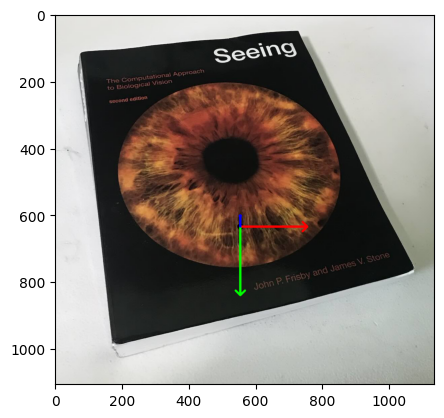

In [16]:
# Draw the projected points on the image
# rgb_image = cv2.cvtColor(frame0, cv2.COLOR_GRAY2RGB)

# Read and display an image (this is just an example image)
img = cv2.imread('stone.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

draw_coordinate_frame(image_points, img)
